In [21]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
# import pytensor
import pytensor.tensor as pt

from pytensor.graph import Apply, Op

import jax as jax
import jax.numpy as jnp
import jax.scipy as jsp
# import pymc.sampling_jax as pmj

from pytensor.link.jax.dispatch import jax_funcify

import polars as pl
import pyarrow as pa
import pandas as pd

from typing import List

%config InlineBackend.figure_format = 'retina'

# setting the style of the plots
sns.set_style('ticks')
plt.style.use('dark_background')

sns.set_context("notebook")

RANDOM_SEED = 104109109
rng = np.random.default_rng(RANDOM_SEED)



In [22]:
# Emission signal and noise parameters
emission_signal_true = 1.15
emission_mu_true = np.array([1, 0, -1], dtype=np.float32)
emission_sigma_true = [0.8, 1.2, 1.414]

p_initial_state_true = np.array([0.9, 0.09, 0.01])

# Probability of switching from state_t to state_t+1
p_transition_true = np.array(
    [
        #  0,   1,   2
        [0.9, 0.09, 0.01],  # 0
        [0.1, 0.8, 0.1],  # 1
        [0.2, 0.1, 0.7],  # 2
    ]
)

# Confirm that we have defined valid probabilities
assert np.isclose(np.sum(p_initial_state_true), 1)
assert np.allclose(np.sum(p_transition_true, axis=-1), 1)

In [23]:
# Let's compute the log of the probalitiy transition matrix for later use
with np.errstate(divide="ignore"):
    logp_initial_state_true = np.log(p_initial_state_true)
    logp_transition_true = np.log(p_transition_true)

logp_initial_state_true, logp_transition_true

(array([-0.10536052, -2.40794561, -4.60517019]),
 array([[-0.10536052, -2.40794561, -4.60517019],
        [-2.30258509, -0.22314355, -2.30258509],
        [-1.60943791, -2.30258509, -0.35667494]]))

In [24]:
# We will observe 70 HMM processes, each with a total of 50 steps
n_obs = 70
n_steps = 20

In [25]:
def simulate_hmm(
    p_initial_state,
    p_transition,
    emission_mu,
    emission_signal,
    emission_sigma,
    n_steps,
    rng,
):
    """Generate hidden state and emission from our HMM model."""

    possible_states = np.array([0, 1, 2])

    hidden_states = []
    initial_state = rng.choice(possible_states, p=p_initial_state)

    # fill in the initial state
    hidden_states.append(initial_state)

    for step in range(n_steps):
        new_hidden_state = rng.choice(
            possible_states, p=p_transition[hidden_states[-1]]
        )
        hidden_states.append(new_hidden_state)
    hidden_states = np.array(hidden_states)

    # generate observations
    emissions = rng.normal(
        jnp.asarray(emission_mu)[hidden_states] * emission_signal,
        jnp.asarray(emission_sigma)[hidden_states],
    )

    return hidden_states, emissions

In [26]:
single_hmm_hidden_state, single_hmm_emission = simulate_hmm(
    p_initial_state_true,
    p_transition_true,
    emission_mu_true,
    emission_signal_true,
    emission_sigma_true,
    n_steps,
    rng,
)
print(single_hmm_hidden_state)
print(np.round(single_hmm_emission, 2))

[0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1]
[ 0.72  3.98 -0.03  0.58  2.61  0.96 -0.06 -0.15  0.52 -2.35 -0.75 -0.48
 -0.53  0.65  1.9   1.33  1.67 -1.88 -1.87 -1.3  -0.95]


In [27]:
# simulate over n_obs individuals
def make_fake_data(n_steps, n_obs, rng):
    df_list = []
    for i in range(n_obs):
        hidden_states, emissions = simulate_hmm(
            p_initial_state_true,
            p_transition_true,
            emission_mu_true,
            emission_signal_true,
            emission_sigma_true,
            n_steps,
            rng,
        )
        df = pl.DataFrame(
            {
                "id": i,
                "time": range((n_steps + 1)),
                "hidden_states": hidden_states,
                "emissions": emissions,
            }
        )

        df = df.with_columns(
            pl.col("id").cast(pl.Utf8).cast(pl.Categorical).alias("id_factor")
        )

        df_list.append(df)

    fake_data = pl.concat(df_list)
    return fake_data


fake_data = make_fake_data(n_steps, 10, rng)

fake_data.head()

<sys>:0: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


id,time,hidden_states,emissions,id_factor
i32,i64,i64,f64,cat
0,0,0,1.603948,"""0"""
0,1,0,1.188485,"""0"""
0,2,0,-0.805881,"""0"""
0,3,0,1.333647,"""0"""
0,4,0,2.183867,"""0"""


Text(0.5, 0.98, 'States and emissions over time')

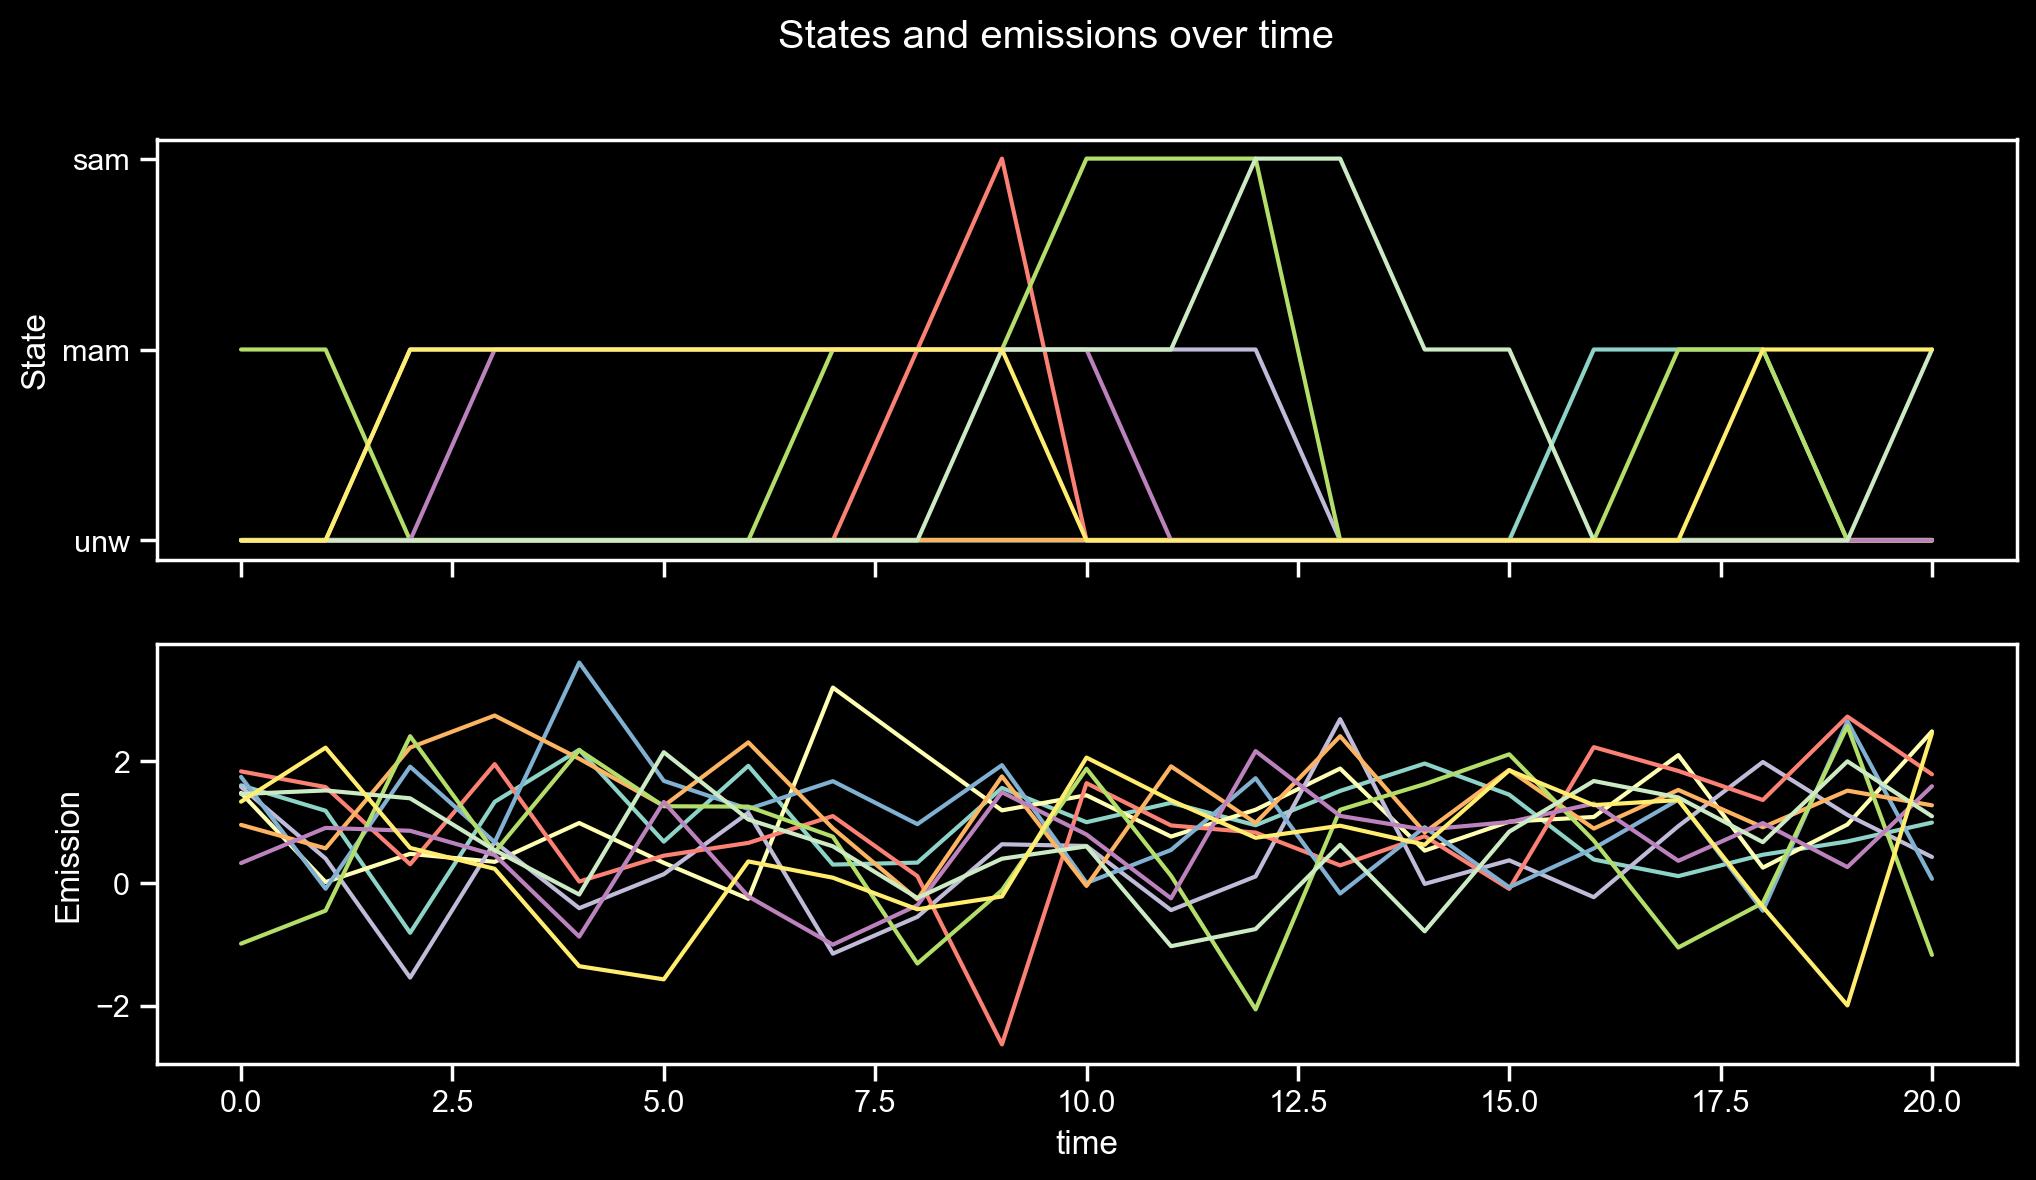

In [28]:
# Plot using seaborn
fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=1, sharex=True)

sns.lineplot(
    data=fake_data,
    x="time",
    y="hidden_states",
    hue="id_factor",
    ax=axs[0],
    legend=None,
)
sns.lineplot(
    data=fake_data,
    x="time",
    y="emissions",
    hue="id_factor",
    ax=axs[1],
    legend=None,
)

axs[0].set_ylabel("State")
axs[0].set_yticks([0, 1, 2])
axs[0].set_yticklabels(["unw", "mam", "sam"])
axs[1].set_ylabel("Emission")
plt.xlabel("time")
fig.suptitle("States and emissions over time")

In [29]:
def hmm_logp(
    emission_observed,
    emission_mu,
    emission_sigma,
    emission_signal,
    logp_initial_state,
    logp_transition,
):
    """Compute the marginal log-likelihood of a single HMM process using a forward algorithm."""

    # Make sure input is (T,) and not something broadcasted weirdly
    emission_observed = jnp.asarray(emission_observed).reshape(-1)

    # Compute log-likelihood of emissions: shape (T, n_states)
    logp_emission = jsp.stats.norm.logpdf(
        emission_observed[:, None],  # shape (T, 1)
        loc=emission_mu * emission_signal,  # shape (n_states,)
        scale=emission_sigma,  # shape (n_states,)
    )  # result shape: (T, n_states)

    # Initialize log-alpha for t=0
    log_alpha = logp_initial_state + logp_emission[0]

    # Forward algorithm using scan
    def forward_step(log_alpha_prev, logp_emit_t):
        log_alpha_t = jsp.special.logsumexp(
            log_alpha_prev[:, None] + logp_transition, axis=0
        )
        return log_alpha_t + logp_emit_t, None

    # log_alpha(x_t) = log p(x_t, y_1:t)
    log_alpha, _ = jax.lax.scan(forward_step, init=log_alpha, xs=logp_emission[1:])

    # Final marginal likelihood: logsumexp over final time step
    return jsp.special.logsumexp(log_alpha)

In [30]:
# testing the function
hmm_logp(
    jnp.asarray(single_hmm_emission),
    jnp.asarray(emission_mu_true),
    jnp.asarray(emission_sigma_true),
    emission_signal_true,
    jnp.asarray(logp_initial_state_true),
    jnp.asarray(logp_transition_true),
)

Array(-40.4741018, dtype=float64)

In [31]:
# vectorising the core function using jax_vmap across multiple individuals


def vec_hmm_logp(*args):
    jax.vmap(
        hmm_logp,
        in_axes=(0, None, None, None, None),
    )
    return jnp.sum(hmm_logp(*args))


# jit this function
vec_hmm_logp_jit = jax.jit(vec_hmm_logp)

# also use jax to give the gradient of the function
jitted_vec_hmm_logp_grad = jax.jit(jax.grad(vec_hmm_logp, argnums=list(range(6))))

In [32]:
# resimulate the data to test the full function with multiple individuals
simulated_emissions = np.zeros((n_obs, n_steps + 1))

for i in range(n_obs):
    _, emissions = simulate_hmm(
        p_initial_state_true,
        p_transition_true,
        emission_mu_true,
        emission_signal_true,
        emission_sigma_true,
        n_steps,
        rng,
    )
    simulated_emissions[i] = emissions

%time 
print(vec_hmm_logp(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_true,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),))

vec_hmm_logp_jit(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_true,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),)

%time 
vec_hmm_logp_jit(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_true,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),)

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.86 μs
-2249.799629126103
CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


Array(-2249.79962913, dtype=float64)

In [33]:
# wrapping the jax jitted function in a pymc3 Op
class HMMLogp(Op):
    def make_node(
        self,
        emission_observed,
        emission_mu,
        emission_sigma,
        emission_signal,
        logp_initial_state,
        logp_transition,
    ):
        # convert the inputs symbolic variables
        inputs = [
            pt.as_tensor_variable(x)
            for x in [
                emission_observed,
                emission_mu,
                emission_sigma,
                emission_signal,
                logp_initial_state,
                logp_transition,
            ]
        ]
        # Define the type of the output returned by the wrapped JAX function
        outputs = [pt.dscalar()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = vec_hmm_logp_jit(*inputs)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

    def grad(self, inputs, output_gradients):
        (
            grad_wrt_emission_observed,
            grad_wrt_emission_mu,
            grad_wrt_emission_sigma,
            grad_wrt_emission_signal,
            grad_wrt_logp_initial_state,
            grad_wrt_logp_transition,
        ) = hmm_logp_grad_op(*inputs)
        output_gradient = output_gradients[0]
        return (
            grad_wrt_emission_observed * output_gradient,
            grad_wrt_emission_mu * output_gradient,
            grad_wrt_emission_sigma * output_gradient,
            grad_wrt_emission_signal * output_gradient,
            grad_wrt_logp_initial_state * output_gradient,
            grad_wrt_logp_transition * output_gradient,
        )


class HMMLogpGrad(Op):
    def make_node(
        self,
        emission_observed,
        emission_mu,
        emission_sigma,
        emission_signal,
        logp_initial_state,
        logp_transition,
    ):
        # convert the inputs symbolic variables
        inputs = [
            pt.as_tensor_variable(x)
            for x in [
                emission_observed,
                emission_mu,
                emission_sigma,
                emission_signal,
                logp_initial_state,
                logp_transition,
            ]
        ]
        # This `Op` will return one gradient per input. For simplicity, we assume
        # each output is of the same type as the input. In practice, you should use
        # the exact dtype to avoid overhead when saving the results of the computation
        # in `perform`
        outputs = [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (
            grad_wrt_emission_observed_result,
            grad_wrt_emission_mu_result,
            grad_wrt_emission_sigma_result,
            grad_wrt_emission_signal_result,
            grad_wrt_logp_initial_state_result,
            grad_wrt_logp_transition_result,
        ) = jitted_vec_hmm_logp_grad(*inputs)
        outputs[0][0] = np.asarray(
            grad_wrt_emission_observed_result, dtype=node.outputs[0].dtype
        )
        outputs[1][0] = np.asarray(
            grad_wrt_emission_mu_result, dtype=node.outputs[1].dtype
        )
        outputs[2][0] = np.asarray(
            grad_wrt_emission_sigma_result, dtype=node.outputs[2].dtype
        )
        outputs[3][0] = np.asarray(
            grad_wrt_emission_signal_result, dtype=node.outputs[3].dtype
        )
        outputs[4][0] = np.asarray(
            grad_wrt_logp_initial_state_result, dtype=node.outputs[4].dtype
        )
        outputs[5][0] = np.asarray(
            grad_wrt_logp_transition_result, dtype=node.outputs[5].dtype
        )


# Initialize the Ops
hmm_logp_op = HMMLogp()
hmm_logp_grad_op = HMMLogpGrad()


hmm_logp_grad_op(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_true,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),
)[1].eval()

hmm_logp_grad_op(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_true,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),
)[5].eval()

array([[832.70320698,  76.42491535,   8.28264354],
       [ 48.76423396, 317.24344347,  40.19375716],
       [ 35.29644388,  13.04339789,  97.04795777]])

In [34]:
# testing the two functions using the .eval() debugger method --
print(
    hmm_logp_op(
        simulated_emissions,
        np.asarray(emission_mu_true),
        np.asarray(emission_sigma_true),
        emission_signal_true,
        np.asarray(logp_initial_state_true),
        np.asarray(logp_transition_true),
    ).eval()
)


print(
    hmm_logp_grad_op(
        simulated_emissions,
        np.asarray(emission_mu_true),
        np.asarray(emission_sigma_true),
        emission_signal_true,
        np.asarray(logp_initial_state_true),
        np.asarray(logp_transition_true),
    )[5].eval()
)

-2249.799630411134
[[832.70320698  76.42491535   8.28264354]
 [ 48.76423396 317.24344347  40.19375716]
 [ 35.29644388  13.04339789  97.04795777]]


In [35]:
# We define the symbolic `emission_signal` variable outside of the `Op`
# so that we can request the gradient wrt to it
emission_signal_variable = pt.as_tensor_variable(emission_signal_true)
x = hmm_logp_op(
    simulated_emissions,
    np.asarray(emission_mu_true),
    np.asarray(emission_sigma_true),
    emission_signal_variable,
    np.asarray(logp_initial_state_true),
    np.asarray(logp_transition_true),
)

x_grad_wrt_emission_signal = pt.grad(x, wrt=emission_signal_variable)
x_grad_wrt_emission_signal.eval()

array(-53.89812215)

In [36]:
with pm.Model() as model:
    # Priors
    emission_signal = pm.Normal("emission_signal", mu=1.15, sigma=0.5, shape=1)
    emission_mu = pm.Normal("emission_mu", mu=[1, 0, -1], sigma=1, shape=3)
    emission_sigma = pm.Exponential(
        "emission_sigma", lam=[1 / 0.8, 1 / 1.2, 1 / 1.414], shape=3
    )

    p_initial_state = pm.Dirichlet("p_initial_state", a=np.ones(3))
    # transform the initial state to log space for the model
    logp_initial_state = pt.log(p_initial_state)

    p_transition = pm.Dirichlet("p_transition", a=np.ones((3, 3)))
    # transform the transition matrix to log space for the model
    logp_transition = pt.log(p_transition)

    # Likelihood
    pm.Potential(
        "hmm_loglik",
        hmm_logp_op(
            simulated_emissions,
            emission_mu,
            emission_sigma,
            emission_signal,
            logp_initial_state,
            logp_transition,
        ),
    )

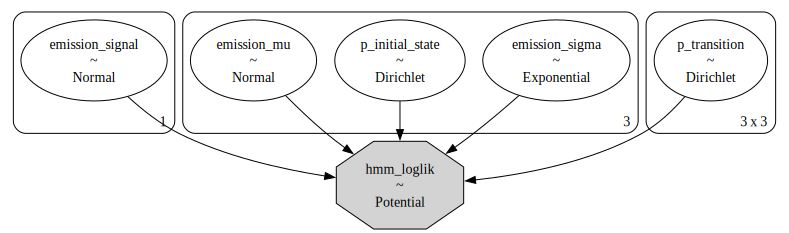

In [37]:
pm.model_to_graphviz(model)

In [38]:
# checking if the model runs for the initial values
initial_point = model.initial_point()
initial_point

{'emission_signal': array([1.15]),
 'emission_mu': array([ 1.,  0., -1.]),
 'emission_sigma_log__': array([-0.22314355,  0.18232156,  0.34642257]),
 'p_initial_state_simplex__': array([0., 0.]),
 'p_transition_simplex__': array([[0., 0.],
        [0., 0.],
        [0., 0.]])}

In [39]:
model.point_logps(initial_point)

{'emission_signal': np.float64(-0.23),
 'emission_mu': np.float64(-2.76),
 'emission_sigma': np.float64(-3.0),
 'p_initial_state': np.float64(-1.5),
 'p_transition': np.float64(-4.51),
 'hmm_loglik': np.float64(-2467.86)}

In [41]:
# getting to sample now! FINALLY!! My first HMM model in PyMC!!!!
with model:
    idata = pm.sample(
        tune=3000,
        draws=1000,
        chains=2,
        cores=1,
        progressbar=True,
        target_accept=0.95,
        # progressbar_theme="dark",
    )

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [emission_signal, emission_mu, emission_sigma, p_initial_state, p_transition]


Output()

Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 1427 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [22]:
import arviz as az

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
emission_signal[0],1.013,0.316,0.453,1.596,0.011,0.009,878.0,499.0,1.01
emission_mu[0],0.530,0.865,-0.985,1.896,0.158,0.039,39.0,656.0,1.07
emission_mu[1],0.006,0.818,-1.286,1.545,0.089,0.037,106.0,442.0,1.02
emission_mu[2],0.158,0.881,-1.212,1.655,0.086,0.023,127.0,656.0,1.04
emission_sigma[0],0.996,0.307,0.653,1.582,0.049,0.021,65.0,627.0,1.08
emission_sigma[1],1.184,0.334,0.687,1.745,0.030,0.007,154.0,787.0,1.02
emission_sigma[2],1.126,0.342,0.655,1.689,0.030,0.007,157.0,640.0,1.03
p_initial_state[0],0.341,0.238,0.002,0.758,0.005,0.003,1983.0,2101.0,1.00
p_initial_state[1],0.327,0.232,0.000,0.747,0.005,0.003,2040.0,1710.0,1.00
p_initial_state[2],0.332,0.238,0.000,0.765,0.004,0.004,3019.0,1732.0,1.00


array([[<Axes: title={'center': 'emission_signal'}>,
        <Axes: title={'center': 'emission_signal'}>],
       [<Axes: title={'center': 'emission_mu'}>,
        <Axes: title={'center': 'emission_mu'}>],
       [<Axes: title={'center': 'emission_sigma'}>,
        <Axes: title={'center': 'emission_sigma'}>],
       [<Axes: title={'center': 'p_initial_state'}>,
        <Axes: title={'center': 'p_initial_state'}>],
       [<Axes: title={'center': 'p_transition'}>,
        <Axes: title={'center': 'p_transition'}>]], dtype=object)

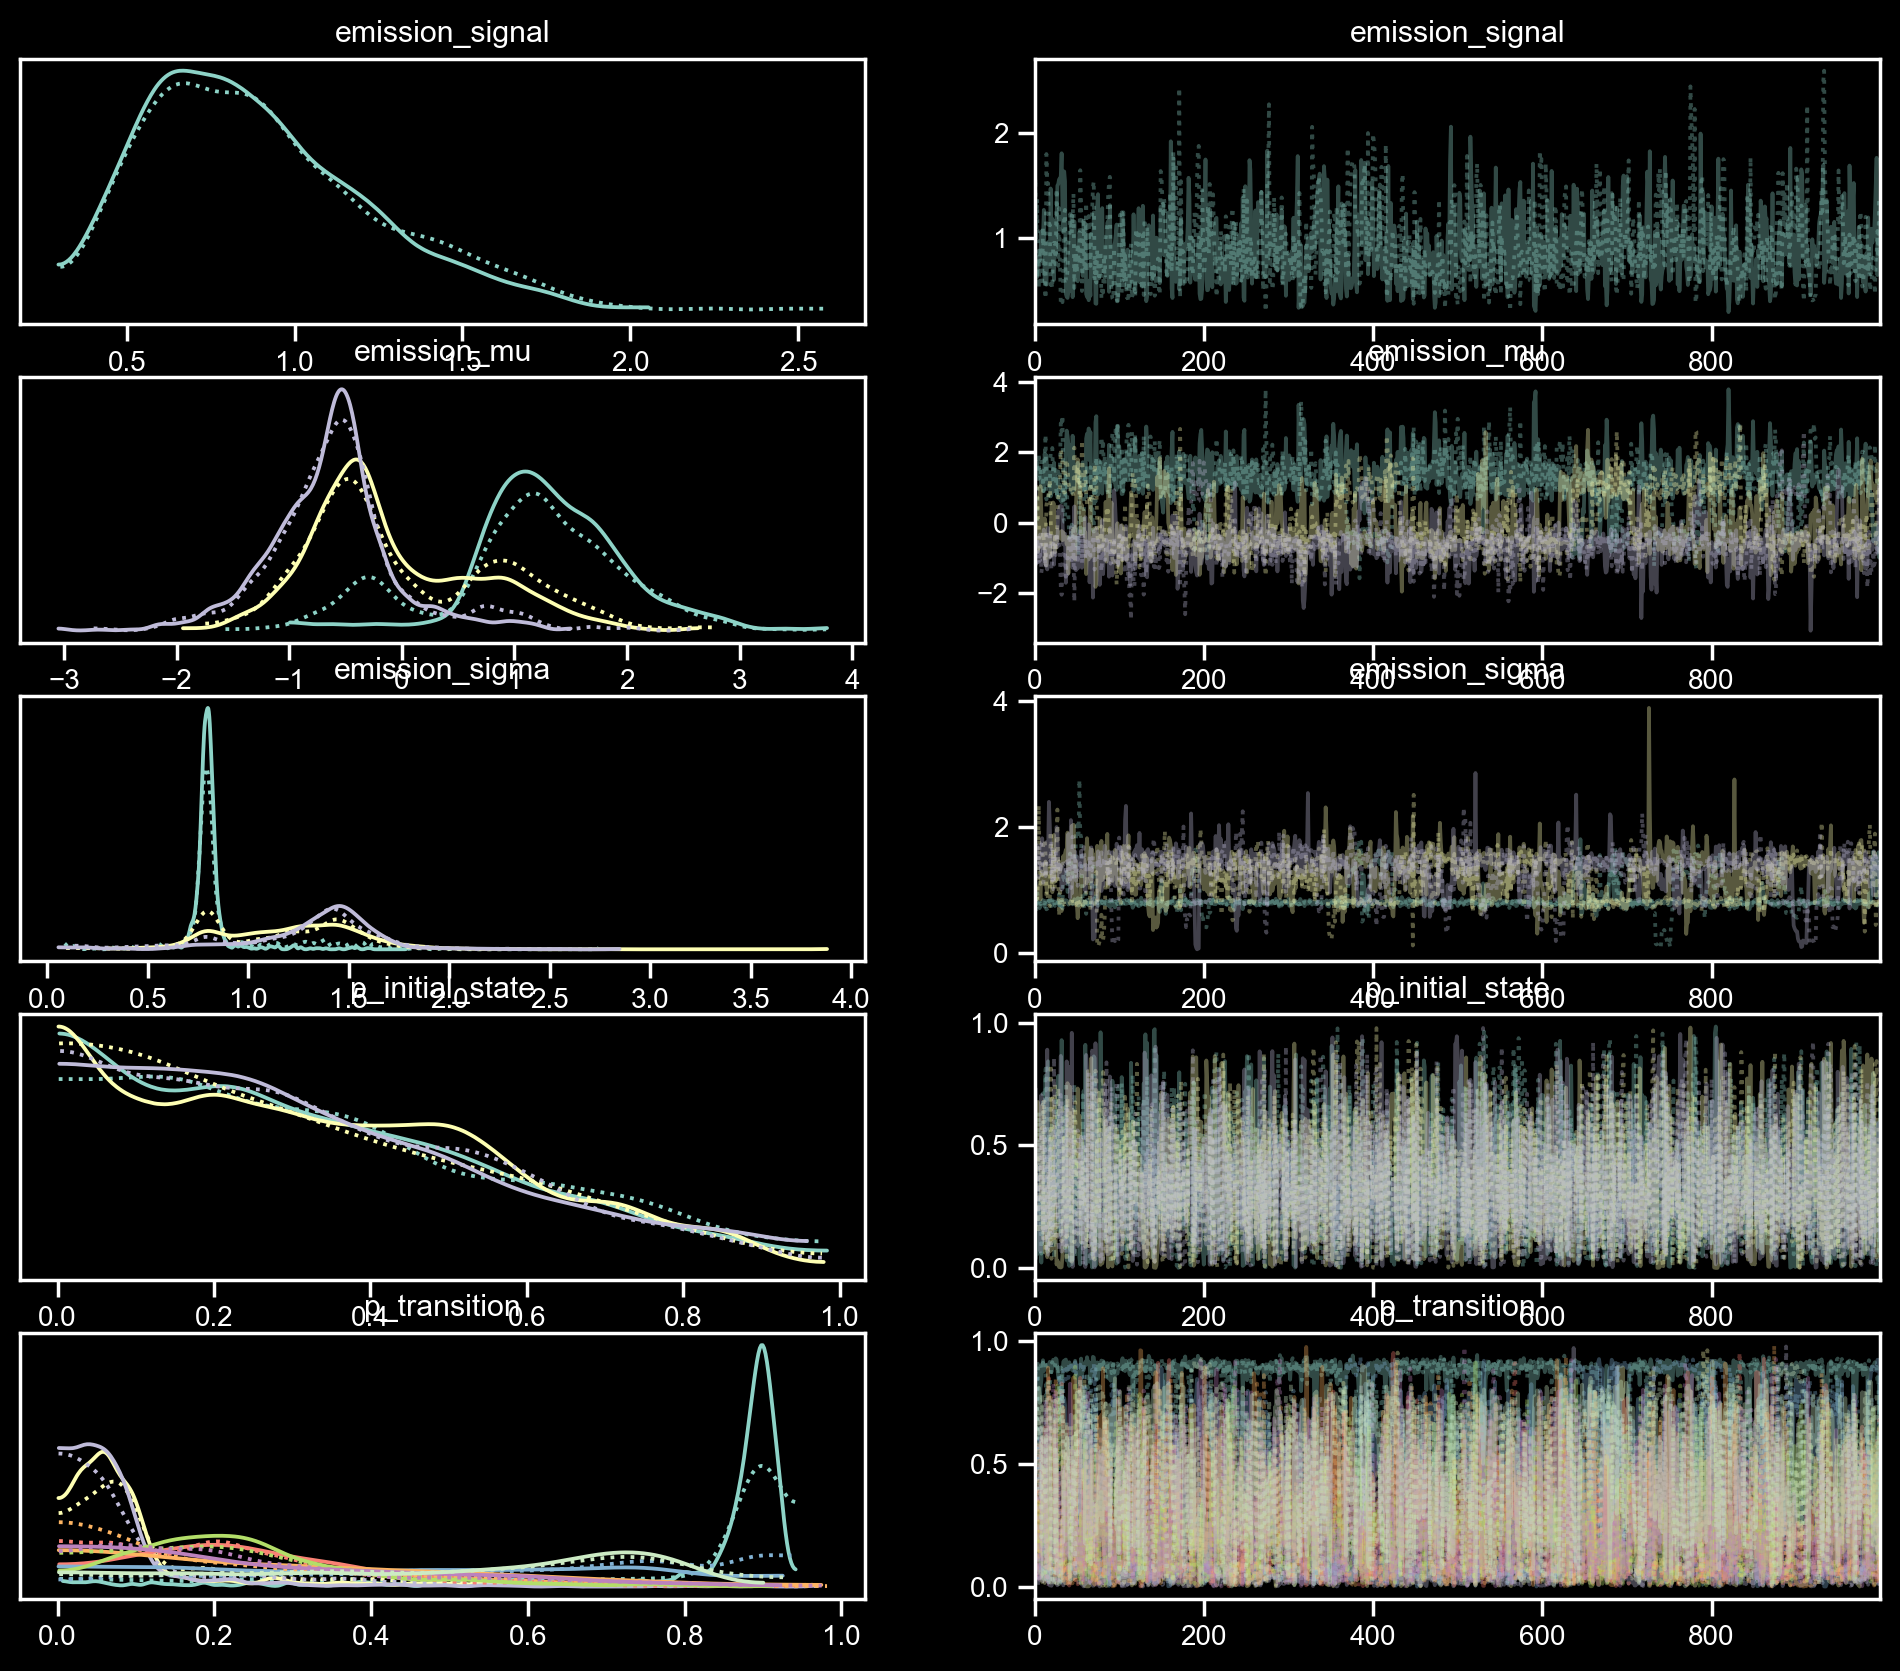

In [42]:
az.plot_trace(idata)